In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from keras.optimizers import Adam
from ipywidgets import interact
import ipywidgets as widgets
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import keras
from sklearn.linear_model import LinearRegression

In [ ]:
ls

In [ ]:
dir_path = 'Step 1. Data Wrangling/'

In [4]:
df_wellA = pd.read_csv(dir_path+'DATA_for_DL_Well_A_data.csv')
df_wellA

,Unnamed: 0,"Depth, m","Porosity, pc",File Name
0,0,3837.55,10.8,15_9_19_A\15_9_19_A_p2_3837.55.png
1,1,3838.50,17.2,15_9_19_A\15_9_19_A_p2_3838.50.png
2,2,3839.40,12.7,15_9_19_A\15_9_19_A_p3_3839.40.png
3,3,3840.45,21.0,15_9_19_A\15_9_19_A_p3_3840.45.png
4,4,3841.45,22.1,15_9_19_A\15_9_19_A_p4_3841.45.png
...,...,...,...,...
147,147,3995.50,18.2,15_9_19_A\15_9_19_A_p79_3995.50.png
148,148,3996.40,15.7,15_9_19_A\15_9_19_A_p79_3996.40.png
149,149,3997.50,11.7,15_9_19_A\15_9_19_A_p80_3997.50.png
150,150,3998.45,15.4,15_9_19_A\15_9_19_A_p80_3998.45.png


In [5]:
X_dataA=[]
y_dataA=[]
for ind in df_wellA.index:
    y_dataA.append(df_wellA['Porosity, pc'][ind])
    im = Image.open((dir_path+df_wellA['File Name'][ind][:-4]).replace('\\','/')+'_left.jpg')
    X_dataA.append(np.array(im))
    #print(ind,df_wellA['Porosity, pc'][ind],df_wellA['File Name'][ind])

In [6]:
y_dataA=np.array(y_dataA)/36
y_dataA.shape

(152,)

In [7]:
X_dataA=np.array(X_dataA)/255
X_dataA.shape

(152, 1536, 1024, 3)

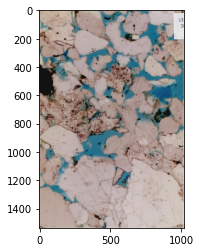

In [8]:
plt.imshow(X_dataA[1,:,:,:])

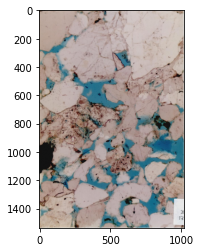

In [9]:
plt.imshow(np.flip(X_dataA,axis=1)[1,:,:,:])

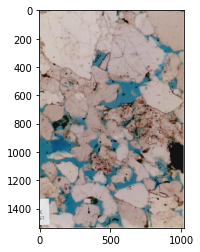

In [10]:
plt.imshow(np.flip(np.flip(X_dataA,axis=1),axis=2)[1,:,:,:])

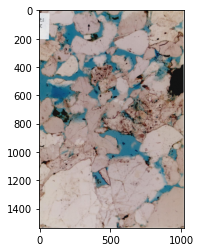

In [11]:
plt.imshow(np.flip(X_dataA,axis=2)[1,:,:,:])

In [12]:
X_dataA=np.concatenate((X_dataA,np.flip(X_dataA,axis=1),np.flip(X_dataA,axis=2),np.flip(np.flip(X_dataA,axis=1),axis=2)),axis=0)
y_dataA=np.concatenate((y_dataA,y_dataA,y_dataA,y_dataA),axis=0)
print(X_dataA.shape)
print(y_dataA.shape)

(608, 1536, 1024, 3)
(608,)


In [14]:
def plot_thin_section(item):
    
    fig, ax = plt.subplots(figsize=(5, 5),frameon=False)
    
    ax.title.set_text('Porosity # '+str(round(y_dataA[item],2)))
    ax.imshow(X_dataA[item,:,:,:])

In [15]:
sliders_item = widgets.IntSlider(min=0, max=X_dataA.shape[0], step=1, value=0, description='Item # ')
interact(plot_thin_section, item=sliders_item)

interactive(children=(IntSlider(value=0, description='Item # ', max=608), Output()), _dom_classes=('widget-int…

<function __main__.plot_thin_section(item)>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_dataA, y_dataA, test_size=0.10, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(547, 1536, 1024, 3)
(61, 1536, 1024, 3)
(547,)
(61,)


In [18]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, stride=(2,2), batchnorm=True):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # add downsampling layer
    g = Conv2D(n_filters, (2,2), strides=stride, padding='same', kernel_initializer=init)(layer_in)
    
    g = MaxPooling2D()(g)
    
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    
    
    # leaky relu activation
    #g = LeakyReLU(alpha=0.2)(g)
    g = Activation('relu')(g)
    
    return g
 
 
    
# define the standalone generator model
def define_generator(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # image input
    in_image = Input(shape=image_shape)
    
    # encoder model
    e1 = define_encoder_block(in_image, 64, stride=(3,2), batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(e4)
    b = Activation('relu')(b)
     
    x = Flatten()(b)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    # check to see if the regression node should be added
    #if regress:
        #x = Dense(1, activation="linear")(x)
    out_image = Dense(1, activation="sigmoid")(x)

    # define model
    model = Model(in_image, out_image)
    
    return model

In [19]:
keras.backend.clear_session()
# define input shape based on the loaded dataset
image_shape = X_train[0].shape

g_model = define_generator(image_shape)

# compile model
opt = Adam(lr=0.001, beta_1=0.5)

g_model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mse']) #, 'mae', 'mean_absolute_percentage_error'

In [20]:
g_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1536, 1024, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512 

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
filepath = "ThinSectionAE_left-model-{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

history = g_model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])

Train on 547 samples, validate on 61 samples
Epoch 1/100
547/547 [==============================] - 89s 163ms/step - loss: 71.2402 - mse: 0.0977 - val_loss: 67.4579 - val_mse: 0.0859

Epoch 00001: val_loss improved from inf to 67.45787, saving model to ThinSectionAE_left-model-01-71.2402-67.4579.hdf5
Epoch 2/100
547/547 [==============================] - 83s 151ms/step - loss: 59.1846 - mse: 0.0748 - val_loss: 78.7478 - val_mse: 0.0741

Epoch 00002: val_loss did not improve from 67.45787
Epoch 3/100
547/547 [==============================] - 83s 152ms/step - loss: 54.1192 - mse: 0.0686 - val_loss: 108.5851 - val_mse: 0.1481

Epoch 00003: val_loss did not improve from 67.45787
Epoch 4/100
547/547 [==============================] - 80s 146ms/step - loss: 52.0984 - mse: 0.0656 - val_loss: 47.0549 - val_mse: 0.0480

Epoch 00004: val_loss improved from 67.45787 to 47.05493, saving model to ThinSectionAE_left-model-04-52.0984-47.0549.hdf5
Epoch 5/100
547/547 [==============================] 


Epoch 00040: val_loss did not improve from 21.17808
Epoch 41/100
547/547 [==============================] - 88s 160ms/step - loss: 23.3563 - mse: 0.0177 - val_loss: 24.0708 - val_mse: 0.0231

Epoch 00041: val_loss did not improve from 21.17808
Epoch 42/100
547/547 [==============================] - 84s 153ms/step - loss: 24.5107 - mse: 0.0173 - val_loss: 31.3991 - val_mse: 0.0186

Epoch 00042: val_loss did not improve from 21.17808
Epoch 43/100
547/547 [==============================] - 87s 159ms/step - loss: 25.8276 - mse: 0.0178 - val_loss: 28.5125 - val_mse: 0.0210

Epoch 00043: val_loss did not improve from 21.17808
Epoch 44/100
547/547 [==============================] - 85s 156ms/step - loss: 24.4685 - mse: 0.0164 - val_loss: 24.4231 - val_mse: 0.0189

Epoch 00044: val_loss did not improve from 21.17808
Epoch 45/100
547/547 [==============================] - 85s 155ms/step - loss: 22.7798 - mse: 0.0162 - val_loss: 26.9989 - val_mse: 0.0159

Epoch 00045: val_loss did not improve f


Epoch 00082: val_loss did not improve from 17.80700
Epoch 83/100
547/547 [==============================] - 85s 155ms/step - loss: 15.1721 - mse: 0.0068 - val_loss: 19.3416 - val_mse: 0.0173

Epoch 00083: val_loss did not improve from 17.80700
Epoch 84/100
547/547 [==============================] - 88s 161ms/step - loss: 14.8696 - mse: 0.0068 - val_loss: 19.7044 - val_mse: 0.0142

Epoch 00084: val_loss did not improve from 17.80700
Epoch 85/100
547/547 [==============================] - 85s 155ms/step - loss: 14.3475 - mse: 0.0068 - val_loss: 20.2949 - val_mse: 0.0133

Epoch 00085: val_loss did not improve from 17.80700
Epoch 86/100
547/547 [==============================] - 88s 161ms/step - loss: 13.6241 - mse: 0.0064 - val_loss: 19.8457 - val_mse: 0.0146

Epoch 00086: val_loss did not improve from 17.80700
Epoch 87/100
547/547 [==============================] - 89s 162ms/step - loss: 12.5871 - mse: 0.0052 - val_loss: 22.0772 - val_mse: 0.0180

Epoch 00088: val_loss did not improve f

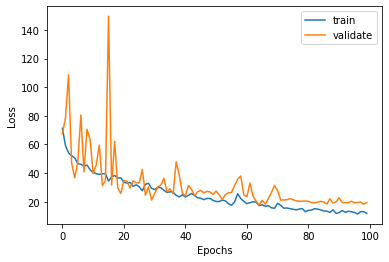

In [23]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

In [31]:
ls

'#2 DL Model Capstone 2 HED.ipynb'
'#2 DL Model Capstone 2.ipynb'
'#2 DL Model Capstone 2 v2_left_and_right_image.ipynb'
'#2 DL Model Capstone 2 v2_left_image.ipynb'
'#2 DL Model Capstone 2 v2-right_Image.ipynb'
 model.png
 savemodels/
'Step 1. Data Wrangling'/


coefficient of determination: 0.6140653649116308


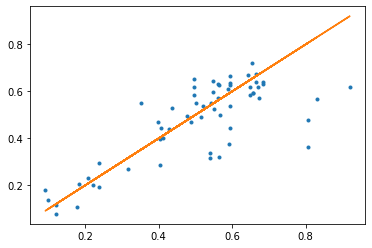

In [25]:
model = load_model('savemodels/ThinSectionAE_left-model-65-17.3143-17.8070.hdf5') #dropout=0.5, max pooling added, lr -.001, filter (2,2) , mpe, batch size 8
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

### Tuning Learning rate

In [ ]:
epochs = np.array(range(10))
x= 1e-8 * 10**(epochs)
plt.semilogy(epochs,x)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch))

history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=32,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[lr_scheduler])

In [ ]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

### Testing 

In [26]:
df_wellbt2 = pd.read_csv(dir_path+'DATA_for_DL-Well_bt2_data.csv')
df_wellbt2

,Unnamed: 0,"Depth, m","Porosity, pc",File Name
0,0,4037.75,21.1,15_9_19_bt2\15_9_19_bt2_p2_4037.75.png
1,1,4038.75,21.7,15_9_19_bt2\15_9_19_bt2_p2_4038.75.png
2,2,4039.75,19.9,15_9_19_bt2\15_9_19_bt2_p3_4039.75.png
3,3,4040.75,21.8,15_9_19_bt2\15_9_19_bt2_p3_4040.75.png
4,4,4041.75,20.9,15_9_19_bt2\15_9_19_bt2_p4_4041.75.png
...,...,...,...,...
61,61,4103.75,24.3,15_9_19_bt2\15_9_19_bt2_p33_4103.75.png
62,62,4104.75,24.0,15_9_19_bt2\15_9_19_bt2_p33_4104.75.png
63,63,4105.80,15.4,15_9_19_bt2\15_9_19_bt2_p34_4105.80.png
64,64,4106.45,15.5,15_9_19_bt2\15_9_19_bt2_p34_4106.45.png


In [33]:
X_databt2=[]
y_databt2=[]
for ind in df_wellbt2.index:
    y_databt2.append(df_wellbt2['Porosity, pc'][ind])
    im = Image.open((dir_path+df_wellbt2['File Name'][ind][:-4]).replace('\\','/')+'_left.jpg')
    X_databt2.append(np.array(im))
    #print(ind,df_wellA['Porosity, pc'][ind],df_wellA['File Name'][ind])

In [34]:
y_databt2=np.array(y_databt2)/36
y_databt2.shape

(66,)

In [35]:
X_databt2=np.array(X_databt2)/255
X_databt2.shape

(66, 1536, 1024, 3)

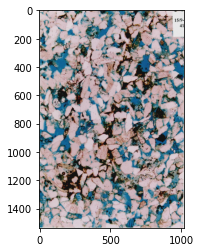

In [36]:
plt.imshow(X_databt2[60,:,:,:])

coefficient of determination: 0.43437569122983966


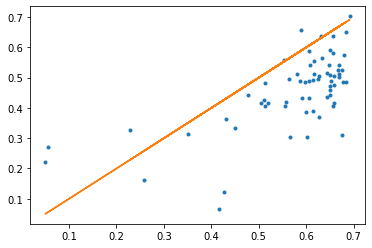

In [37]:
model = load_model('savemodels/ThinSectionAE_left-model-65-17.3143-17.8070.hdf5') #max pooling added, lr -.001, filter (2,2), mpe
X_test_predict = model.predict(X_databt2)
plt.plot(y_databt2,X_test_predict,'.')
plt.plot(y_databt2,y_databt2,'-')
linear = LinearRegression()
linear.fit(y_databt2.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_databt2.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

### Training on both datasets

In [38]:
X_databt2=np.concatenate((X_databt2,np.flip(X_databt2,axis=1),np.flip(X_databt2,axis=2),np.flip(np.flip(X_databt2,axis=1),axis=2)),axis=0)
y_databt2=np.concatenate((y_databt2,y_databt2,y_databt2,y_databt2),axis=0)
print(X_databt2.shape)
print(y_databt2.shape)

(264, 1536, 1024, 3)
(264,)


In [39]:
X_data = np.concatenate((X_dataA,X_databt2),axis=0)
y_data = np.concatenate((y_dataA,y_databt2),axis=0)
print(X_data.shape)
print(y_data.shape)

(872, 1536, 1024, 3)
(872,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(784, 1536, 1024, 3)
(88, 1536, 1024, 3)
(784,)
(88,)


In [41]:
keras.backend.clear_session()
# define input shape based on the loaded dataset
image_shape = X_train[0].shape

g_model = define_generator(image_shape)

# compile model
opt = Adam(lr=0.001, beta_1=0.5)

g_model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mse']) #, 'mae', 'mean_absolute_percentage_error

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
filepath = "ThinSectionAE_left-2wells-model-{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

history = g_model.fit(X_train, y_train,
          epochs=200,
          batch_size=32,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])

Train on 784 samples, validate on 88 samples
Epoch 1/200
784/784 [==============================] - 176s 225ms/step - loss: 63.2279 - mse: 0.0936 - val_loss: 118.5565 - val_mse: 0.1511

Epoch 00001: val_loss improved from inf to 118.55649, saving model to ThinSectionAE_left-2wells-model-01-63.2279-118.5565.hdf5
Epoch 2/200
784/784 [==============================] - 109s 139ms/step - loss: 53.3873 - mse: 0.0769 - val_loss: 74.9226 - val_mse: 0.1057

Epoch 00002: val_loss improved from 118.55649 to 74.92258, saving model to ThinSectionAE_left-2wells-model-02-53.3873-74.9226.hdf5
Epoch 3/200
784/784 [==============================] - 111s 141ms/step - loss: 47.3761 - mse: 0.0660 - val_loss: 73.6653 - val_mse: 0.0970

Epoch 00003: val_loss improved from 74.92258 to 73.66528, saving model to ThinSectionAE_left-2wells-model-03-47.3761-73.6653.hdf5
Epoch 4/200
784/784 [==============================] - 112s 143ms/step - loss: 43.3575 - mse: 0.0560 - val_loss: 85.5248 - val_mse: 0.0877

Epoch 

784/784 [==============================] - 113s 144ms/step - loss: 15.0574 - mse: 0.0076 - val_loss: 30.3346 - val_mse: 0.0223

Epoch 00041: val_loss did not improve from 26.11945
Epoch 42/200
784/784 [==============================] - 111s 141ms/step - loss: 13.7877 - mse: 0.0061 - val_loss: 26.9975 - val_mse: 0.0229

Epoch 00042: val_loss did not improve from 26.11945
Epoch 43/200
784/784 [==============================] - 111s 142ms/step - loss: 14.1288 - mse: 0.0068 - val_loss: 33.2798 - val_mse: 0.0226

Epoch 00043: val_loss did not improve from 26.11945
Epoch 44/200
784/784 [==============================] - 110s 140ms/step - loss: 14.4721 - mse: 0.0065 - val_loss: 30.2136 - val_mse: 0.0225

Epoch 00044: val_loss did not improve from 26.11945
Epoch 45/200
784/784 [==============================] - 112s 143ms/step - loss: 13.6166 - mse: 0.0058 - val_loss: 30.3883 - val_mse: 0.0223

Epoch 00045: val_loss did not improve from 26.11945
Epoch 46/200
784/784 [==========================


Epoch 00083: val_loss did not improve from 26.11945
Epoch 84/200
784/784 [==============================] - 113s 144ms/step - loss: 9.6747 - mse: 0.0032 - val_loss: 31.4177 - val_mse: 0.0218

Epoch 00084: val_loss did not improve from 26.11945
Epoch 85/200
784/784 [==============================] - 110s 140ms/step - loss: 9.7544 - mse: 0.0031 - val_loss: 32.5793 - val_mse: 0.0214

Epoch 00085: val_loss did not improve from 26.11945
Epoch 86/200
784/784 [==============================] - 113s 144ms/step - loss: 9.8415 - mse: 0.0032 - val_loss: 30.3492 - val_mse: 0.0202

Epoch 00086: val_loss did not improve from 26.11945
Epoch 87/200
784/784 [==============================] - 110s 140ms/step - loss: 10.3335 - mse: 0.0031 - val_loss: 32.8379 - val_mse: 0.0210

Epoch 00087: val_loss did not improve from 26.11945
Epoch 88/200
784/784 [==============================] - 112s 143ms/step - loss: 11.2783 - mse: 0.0033 - val_loss: 33.7028 - val_mse: 0.0224

Epoch 00088: val_loss did not improve

784/784 [==============================] - 507s 647ms/step - loss: 10.3574 - mse: 0.0033 - val_loss: 30.5914 - val_mse: 0.0216

Epoch 00126: val_loss did not improve from 26.11945
Epoch 127/200
784/784 [==============================] - 740s 944ms/step - loss: 10.5381 - mse: 0.0029 - val_loss: 29.8437 - val_mse: 0.0198

Epoch 00127: val_loss did not improve from 26.11945
Epoch 128/200
784/784 [==============================] - 225s 287ms/step - loss: 9.8676 - mse: 0.0029 - val_loss: 29.5463 - val_mse: 0.0214

Epoch 00128: val_loss did not improve from 26.11945
Epoch 129/200
784/784 [==============================] - 316s 402ms/step - loss: 10.0805 - mse: 0.0028 - val_loss: 30.0283 - val_mse: 0.0226

Epoch 00129: val_loss did not improve from 26.11945
Epoch 130/200
784/784 [==============================] - 99s 127ms/step - loss: 9.9568 - mse: 0.0030 - val_loss: 29.2232 - val_mse: 0.0214

Epoch 00131: val_loss did not improve from 26.11945
Epoch 132/200
784/784 [========================

KeyboardInterrupt: 

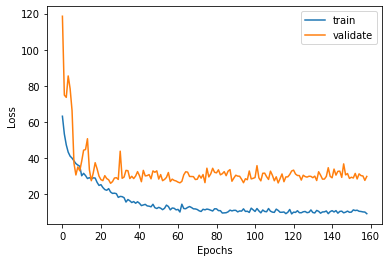

In [42]:
# plot training history
plt.plot(g_model.history.history['loss'], label='train')
plt.plot(g_model.history.history['val_loss'], label='validate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Learning_rate=Variable')
plt.legend()
plt.show()

In [43]:
mv ThinSectionAE_left-2wells-model-26-21.3001-26.1195.hdf5 savemodels/

coefficient of determination: 0.5271259815910249


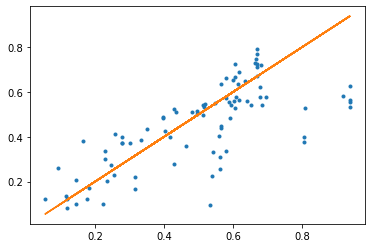

In [48]:
model = load_model('savemodels/ThinSectionAE_left-2wells-model-26-21.3001-26.1195.hdf5') #max pooling added, lr -.001, filter (2,2), mpe
X_test_predict = model.predict(X_test)
plt.plot(y_test,X_test_predict,'.')
plt.plot(y_test,y_test,'-')
linear = LinearRegression()
linear.fit(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
r_sq = linear.score(y_test.reshape(X_test_predict.shape[0],X_test_predict.shape[1]),X_test_predict.reshape(X_test_predict.shape[0],X_test_predict.shape[1]))
print('coefficient of determination:', r_sq)

(array([ 7.,  0.,  0.,  0.,  3., 12.,  0., 13.,  4., 10.,  0.,  7.,  0.,
         3., 15.,  0.,  8.,  0.,  5., 15.,  3., 10.,  4.,  5.,  0.,  4.,
         3.,  0., 14.,  3.,  0., 11.,  0.,  4.,  0.,  0., 10., 19., 15.,
        10.,  7.,  0.,  4.,  3.,  4., 23., 12., 18., 30., 18.,  7., 10.,
        19., 11., 19., 17., 19., 41., 31., 37., 24., 19., 23., 47., 22.,
        31., 28.,  8.,  3.,  4.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  5.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         3.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([0.05  , 0.0595, 0.069 , 0.0785, 0.088 , 0.0975, 0.107 , 0.1165,
        0.126 , 0.1355, 0.145 , 0.1545, 0.164 , 0.1735, 0.183 , 0.1925,
        0.202 , 0.2115, 0.221 , 0.2305, 0.24  , 0.2495, 0.259 , 0.2685,
        0.278 , 0.2875, 0.297 , 0.3065, 0.316 , 0.3255, 0.335 , 0.3445,
        0.354 , 0.3635, 0.373 , 0.3825, 0.392 , 0.4015, 0.411 , 0.4205,
        0.43  , 0.4395, 0.449 , 0.4585, 0.468 , 0.4775, 0.487 , 0.4965,
  

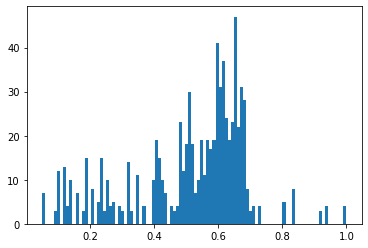

In [50]:
plt.hist(y_train,bins=100)